In [2]:
import datetime
import pprint
import pyaurorax
import cartopy.crs

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

# Step 1 - download and read necessary data

In [3]:
# download a minute of THEMIS data from several sites
dataset_name = "THEMIS_ASI_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 40)
end_dt = start_dt
site_uid_list = sorted(["atha", "fsmi", "gill", "talo", "inuv"])
data_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

In [4]:
# read the data site-by-site, since we need this separation for mosaicing
data_list = []
for site_uid, download_obj in data_download_objs.items():
    data_list.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

In [5]:
# get the list of skymaps available
skymap_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(
        "THEMIS_ASI_SKYMAP_IDLSAV",
        datetime.datetime(2022, 1, 1, 0, 0),
        datetime.datetime(2024, 1, 1, 0, 0),
        site_uid=site_uid,
    )
    skymap_download_objs[site_uid] = download_obj

In [6]:
# show skymaps downloaded so we can figure out which ones we want to use
for site_uid, download_obj in skymap_download_objs.items():
    print(site_uid)
    pprint.pprint(download_obj.filenames)
    print()

atha
[PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/atha/atha_20220321/themis_skymap_atha_20220321-+_v02.sav'),
 PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/atha/atha_20230115/themis_skymap_atha_20230115-+_v02.sav'),
 PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/atha/atha_20230914/themis_skymap_atha_20230914-+_v02.sav')]

fsmi
[PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/fsmi/fsmi_20220309/themis_skymap_fsmi_20220309-+_v02.sav'),
 PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/fsmi/fsmi_20230321/themis_skymap_fsmi_20230321-+_v02.sav'),
 PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/fsmi/fsmi_20230916/themis_skymap_fsmi_20230916-+_v02.sav')]

gill
[PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/gill/gill_20220301/themis_skymap_gill_20220301-+_v02.sav'),
 PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/gill/gill_20230220/themis_skymap_gill_20230220-+_v02.sav'),

In [7]:
skymap_files_to_use = [
    skymap_download_objs["atha"].filenames[1],
    skymap_download_objs["fsmi"].filenames[1],  # the later one is a better skymap
    skymap_download_objs["gill"].filenames[1],
    skymap_download_objs["inuv"].filenames[1],  # the later one is a better skymap
    skymap_download_objs["talo"].filenames[2],
]
pprint.pprint(skymap_files_to_use)

[PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/atha/atha_20230115/themis_skymap_atha_20230115-+_v02.sav'),
 PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/fsmi/fsmi_20230321/themis_skymap_fsmi_20230321-+_v02.sav'),
 PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/gill/gill_20230220/themis_skymap_gill_20230220-+_v02.sav'),
 PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/inuv/inuv_20230312/themis_skymap_inuv_20230312-+_v02.sav'),
 PosixPath('/home/josh/pyaurorax_data/THEMIS_ASI_SKYMAP_IDLSAV/talo/talo_20230214/themis_skymap_talo_20230214-+_v02.sav')]


In [8]:
# read in skymap data
dataset = skymap_download_objs["atha"].dataset  # dataset is the same for all sites, so we just use one of them for reading
skymaps = aurorax.data.ucalgary.read(dataset, skymap_files_to_use)
skymaps

Data(data=[5 Skymap objects], timestamp=[], metadata=[], problematic_files=[], calibrated_data=None, dataset=Dataset(name=THEMIS_ASI_SKYMAP_IDLSAV, short_description='THEMIS All Sky Im...))

# Step 2 - prepare skymap data

In [9]:
# if we're not sure which altitudes are pre-computed, we can see them inside a skymap file
#
# if you choose different altitude when preparing the skymap data, the function will take longer
# to process as it performs an interpolation between the pre-computed altitudes
print("Available pre-computed altitudes: %s" % (', '.join(["%d" % (x / 1000.) for x in skymaps.data[0].full_map_altitude])))

Available pre-computed altitudes: 90, 110, 150


In [10]:
# prepare the skymap data
prepped_skymap = at.mosaic.prep_skymaps(skymaps.data, 110, n_parallel=5)
prepped_skymap

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

MosaicSkymap(polyfill_lat=array(dims=(5, 65536), dtype=float64), polyfill_lon=array(dims=(5, 65536), dtype=float64), elevation=array(dims=(65536,), dtype=float32), site_uid_list=['atha', 'fsmi', 'gill', 'inuv', 'talo'])

# Step 3 - prepare the image data

In [11]:
# prepare the image data
prepped_images = at.mosaic.prep_images(data_list)
prepped_images

MosaicData(images=Dict[5 sites of array(dims=(256, 256))], timestamps=[20 timestamps], site_uid_list=['atha', 'fsmi', 'gill', 'inuv', 'talo'])

# Step 4 - generate the mosaic

In [12]:
# define the intensity scales for each site
scale = {
    "fsmi": [2000, 10000],
    "inuv": [2000, 5500],
    "atha": [2000, 6000],
    "gill": [2000, 10000],
    "talo": [2000, 6000],
}

# Set timestamp to actually create mosaic frame for
mosaic_dt = datetime.datetime(2023, 2, 24, 6, 40, 45)

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images, prepped_skymap, mosaic_dt, projection_obj, image_intensity_scales=scale)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


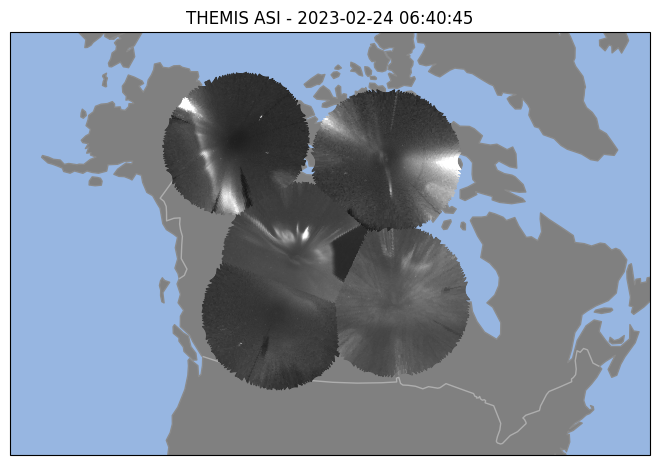

In [13]:
# plot mosaic
map_extent = [-145, -65, 35, 80]
mosaic.plot(map_extent, title="THEMIS ASI - %s" % (mosaic_dt.strftime("%Y-%m-%d %H:%M:%S")))